# Delayed Stop BFNW

A partir das análises feitas nas seções anteriores, concluimos que o BFNW faz um *tradeoff* entre tempo de execução e qualidade da solução: o tempo economizado em relação ao NW original é muito grande, porém, dependendo das sequências sendo alinhadas, a qualidade da solução fica muito prejudicada. Para explicar porque essa perda na qualidade ocorre, devemos revisitar a versão de alinhamento múltiplo desenvolvido na seção anterior (os algoritmos são tecnicamente diferentes, mas a estratégia de execução é exatamente a mesma), afinal, para esse algoritmo, é mais fácil visualizar um efeito negativo dessa implementação: especialmente no início da execução, toda vez que o algoritmo encontra um "sub-alinhamento" minimamente bom (mesmo que seja relativamente ruim na prática), ele "aceita" esse resultado e avança rapidamente a execução até chegar na sua condição de parada. Nesse caso, ele tende a não voltar para buscar por soluções melhores, simulando algo como cair em um máximo local.  

Na sua implementação padrão, o BFNW usa uma *heap* para caminhar do nó fonte até o sumidouro e sua execução dura até a *heap* ficar vazia ou até o **nó sumidouro for alcançado pela 1ª vez**. Se a *heap* ficar vazia, não há mais o que processar. Por outro lado, interromper imediatamente assim que se alcança o sumidouro é uma condição de parada discutivelmente precoce e abrupta. Portanto, na implementação a seguir, iremos construir o **Delayed Stop Best-First Needleman-Wunsch** (ds-BFNW) que "atrasa" ou adia a condição de parada em algumas iterações para incentivar uma busca mais expressiva por soluções melhores ao permitir que o algoritmo expanda mais nós antes de finalizar.

In [1]:
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.constantes as constantes
import utils.func_utils as func_utils
import utils.maxheap as maxheap
import nw_original.nw_original as nw_original

In [2]:
class NodoAuxiliar:

    def __init__(self, i, j, valor_acumulado, direcao):
        self.i = i
        self.j = j
        self.valor_acumulado = valor_acumulado
        self.direcao = direcao

    def __str__(self):
        return "i: " + str(self.i) + ",j: " + str(self.j) + ", va: " + str(self.valor_acumulado) + ", dir: " + str(self.direcao)

    def __repr__(self):
        return str(self)

    def __lt__(self, other):
        return self.valor_acumulado < other.valor_acumulado

    def __le__(self, other):
        return self.valor_acumulado <= other.valor_acumulado

    def __gt__(self, other):
        return self.valor_acumulado > other.valor_acumulado

    def __ge__(self, other):
        return self.valor_acumulado >= other.valor_acumulado

In [3]:
def delayed_stop_bfnw(
    v,
    w,
    num_stops,
    matriz_pontuacao=constantes.matriz_pontuacao_blosum62,
    dicionario_indice_alfabeto=constantes.dicionario_indice_alfabeto_all_amino,
    penalidade_indel=constantes.PENALIDADE_INDEL):
    
    len_v = len(v)
    len_w = len(w)

    fonte = NodoAuxiliar(0, 0, 0, -np.inf)
    heap = maxheap.MaxHeap()
    heap.insert(fonte)

    matriz_similaridade = np.ones((len_v+1, len_w+1)) * (-np.inf)
    matriz_posicionamento = np.ones((len_v+1, len_w+1)) * (-np.inf)

    while not heap.isEmpty():
        # Buscando o melhor vértice ou nó ainda aberto "k" (nesse algorítmo, o com maior valor)
        k = heap.extractMax()

        # Verificando se chegou no sumidouro e atualizando o contador para a condição de parada
        if k.i == len_v and k.j == len_w:
            num_stops-=1
        
        # Fechando esse nó, apenas se o valor dele for maior que o que já foi computado:
        if k.valor_acumulado > matriz_similaridade[k.i, k.j]:
            matriz_similaridade[k.i, k.j] = k.valor_acumulado
            matriz_posicionamento[k.i, k.j] = k.direcao
        else:
            """Mesma condição de parada mais abaixo. Replicamos ela aqui pois a
            parada tem que ser feita mesmo que o resultado não melhore (antes
            desse continue)"""
            if num_stops <= 0:
                break
            
            continue

        """
        Condição de parada. Verificando se essa é a "num_stops"-ésima vez que
        chegou no vértice sumidouro.
        """
        if num_stops <= 0:
            break

        # Computando os próximos vértices

        # Casando elemento de v com inserção em w, vai pra baixo:
        if k.i < len_v:
            no_baixo = NodoAuxiliar(k.i+1, k.j, k.valor_acumulado - penalidade_indel, 0)
            heap.insert(no_baixo)

        # Casando elemento de w com inserção em v, vai pra direita:
        if k.j < len_w:
            no_direita = NodoAuxiliar(k.i, k.j+1, k.valor_acumulado - penalidade_indel, 1)
            heap.insert(no_direita)

        # Casamento, vai para "baixo-direita" (Se vai dar match mesmo ('T' == 'T') ou deu
        # mismatch ('G' != 'T'), não importa. Isso está mapeado na matriz de pontuação)
        if k.i < len_v and k.j < len_w:
            valor_match = matriz_pontuacao[dicionario_indice_alfabeto[v[k.i]], dicionario_indice_alfabeto[w[k.j]]]
            no_baixo_direita = NodoAuxiliar(k.i+1, k.j+1, k.valor_acumulado + valor_match, 2)
            heap.insert(no_baixo_direita)

    return matriz_posicionamento, matriz_similaridade

In [4]:
def executar_alinhamento_e_printar_valores(v, w, num_stops):
    
    print("Alinhamento global par-a-par com o BFNW configurado para", num_stops, "paradas, para as strings a seguir:")
    print(v)
    print(w)
    print("----------------------")
    
    matriz_posicionamento, matriz_similaridade = delayed_stop_bfnw(v, w, num_stops)

    print("\nMatriz de posicionamento (equivale ao mapa de posicionamento):")
    print(matriz_posicionamento)

    print("\nMapa de Posicionamento")
    print(func_utils.computar_mapa_posicionamento(matriz_posicionamento))
    print("----------------------")

    print("Matriz de similaridade:")
    print(matriz_similaridade)

    print("\nMaior Pontuação: ", matriz_similaridade[len(v), len(w)])

    alin_v, alin_w = func_utils.computar_alinhamento(v, w, matriz_posicionamento)
    print("\nAlinhamento")
    print(alin_v)
    print(alin_w)

In [5]:
executar_alinhamento_e_printar_valores(v="DRQT", w="DRQT", num_stops=1)

Alinhamento global par-a-par com o BFNW configurado para 1 paradas, para as strings a seguir:
DRQT
DRQT
----------------------

Matriz de posicionamento (equivale ao mapa de posicionamento):
[[-inf -inf -inf -inf -inf]
 [-inf   2. -inf -inf -inf]
 [-inf -inf   2. -inf -inf]
 [-inf -inf -inf   2. -inf]
 [-inf -inf -inf -inf   2.]]

Mapa de Posicionamento
          
  \       
    \     
      \   
        \ 

----------------------
Matriz de similaridade:
[[  0. -inf -inf -inf -inf]
 [-inf   6. -inf -inf -inf]
 [-inf -inf  11. -inf -inf]
 [-inf -inf -inf  16. -inf]
 [-inf -inf -inf -inf  21.]]

Maior Pontuação:  21.0

Alinhamento
DRQT
DRQT


In [6]:
executar_alinhamento_e_printar_valores(v="DRET", w="DRQT", num_stops=1)

Alinhamento global par-a-par com o BFNW configurado para 1 paradas, para as strings a seguir:
DRET
DRQT
----------------------

Matriz de posicionamento (equivale ao mapa de posicionamento):
[[-inf -inf -inf -inf -inf]
 [-inf   2. -inf -inf -inf]
 [-inf -inf   2. -inf -inf]
 [-inf -inf -inf   2. -inf]
 [-inf -inf -inf -inf   2.]]

Mapa de Posicionamento
          
  \       
    \     
      \   
        \ 

----------------------
Matriz de similaridade:
[[  0. -inf -inf -inf -inf]
 [-inf   6. -inf -inf -inf]
 [-inf -inf  11. -inf -inf]
 [-inf -inf -inf  13. -inf]
 [-inf -inf -inf -inf  18.]]

Maior Pontuação:  18.0

Alinhamento
DRET
DRQT


In [7]:
executar_alinhamento_e_printar_valores(v="DRNTAQLLGTDTT", w="DRQTAQAAGTTTIT", num_stops=4)

Alinhamento global par-a-par com o BFNW configurado para 4 paradas, para as strings a seguir:
DRNTAQLLGTDTT
DRQTAQAAGTTTIT
----------------------

Matriz de posicionamento (equivale ao mapa de posicionamento):
[[-inf   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.]
 [  0.   2.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.]
 [  0.   0.   2.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.]
 [  0.   0.   0.   2.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.]
 [  0.   0.   0.   0.   2.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.]
 [  0.   0.   0.   0.   0.   2.   1.   1.   1.   1.   1.   1.   1.   1.
    1.]
 [  0.   0.   0.   2.   0.   0.   2.   1.   1.   1.   1.   1.   1.   1.
    1.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.   1.   0.   2.
    1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   2.   1.   2.   1.   1.   1.   1

In [8]:
executar_alinhamento_e_printar_valores(v="DRNTAQLLGTDTT", w="DRQTAQAAGTTTIT", num_stops=3)

Alinhamento global par-a-par com o BFNW configurado para 3 paradas, para as strings a seguir:
DRNTAQLLGTDTT
DRQTAQAAGTTTIT
----------------------

Matriz de posicionamento (equivale ao mapa de posicionamento):
[[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf   2. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf   2. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf   0.   2. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf   2. -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf -inf   2. -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf -inf -inf   2.   1. -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf -inf -inf   0.   1.   1.   1. -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf -inf -inf   0. -inf   0. -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf -inf -inf -inf   2.   1.   2. -inf -inf -inf -in

### Teste isolado com v="EQW" e w="EAQ"

A principal característica desse código é a inserção de um novo parâmetro "`num_stops`", que atua como um contador para a quantidade de vezes que o nó sumidouro deve ser atingido até que o algoritmo pare o processamento. Nos exemplos a seguir, executamos uma série de testes isolados ao alinhar as sequências v=”EQW” e w=”EAQ” com o número de paradas (valor do parâmetro num_stops) variando de 1 a 4:

In [9]:
executar_alinhamento_e_printar_valores(v="EQW", w="EAQ", num_stops=1)

Alinhamento global par-a-par com o BFNW configurado para 1 paradas, para as strings a seguir:
EQW
EAQ
----------------------

Matriz de posicionamento (equivale ao mapa de posicionamento):
[[-inf -inf -inf -inf]
 [-inf   2.   1. -inf]
 [-inf   0. -inf   2.]
 [-inf -inf -inf   0.]]

Mapa de Posicionamento
        
  \ _   
  |   \ 
      | 

----------------------
Matriz de similaridade:
[[  0. -inf -inf -inf]
 [-inf   5.   5. -inf]
 [-inf   5. -inf  10.]
 [-inf -inf -inf  10.]]

Maior Pontuação:  10.0

Alinhamento
E-QW
EAQ-


In [10]:
executar_alinhamento_e_printar_valores(v="EQW", w="EAQ", num_stops=2)

Alinhamento global par-a-par com o BFNW configurado para 2 paradas, para as strings a seguir:
EQW
EAQ
----------------------

Matriz de posicionamento (equivale ao mapa de posicionamento):
[[-inf -inf -inf -inf]
 [-inf   2.   1.   1.]
 [-inf   0.   0.   2.]
 [-inf   0.   1.   0.]]

Mapa de Posicionamento
        
  \ _ _ 
  | | \ 
  | _ | 

----------------------
Matriz de similaridade:
[[  0. -inf -inf -inf]
 [-inf   5.   5.   5.]
 [-inf   5.   5.  10.]
 [-inf   5.   5.  10.]]

Maior Pontuação:  10.0

Alinhamento
E-QW
EAQ-


In [11]:
executar_alinhamento_e_printar_valores(v="EQW", w="EAQ", num_stops=3)

Alinhamento global par-a-par com o BFNW configurado para 3 paradas, para as strings a seguir:
EQW
EAQ
----------------------

Matriz de posicionamento (equivale ao mapa de posicionamento):
[[-inf -inf -inf -inf]
 [-inf   2.   1.   1.]
 [-inf   0.   0.   2.]
 [-inf   0.   1.   0.]]

Mapa de Posicionamento
        
  \ _ _ 
  | | \ 
  | _ | 

----------------------
Matriz de similaridade:
[[  0. -inf -inf -inf]
 [-inf   5.   5.   5.]
 [-inf   5.   5.  10.]
 [-inf   5.   5.  10.]]

Maior Pontuação:  10.0

Alinhamento
E-QW
EAQ-


In [12]:
executar_alinhamento_e_printar_valores(v="EQW", w="EAQ", num_stops=4)

Alinhamento global par-a-par com o BFNW configurado para 4 paradas, para as strings a seguir:
EQW
EAQ
----------------------

Matriz de posicionamento (equivale ao mapa de posicionamento):
[[-inf   1.   1.   1.]
 [  0.   2.   1.   1.]
 [  0.   0.   0.   2.]
 [  0.   0.   1.   0.]]

Mapa de Posicionamento
  _ _ _ 
| \ _ _ 
| | | \ 
| | _ | 

----------------------
Matriz de similaridade:
[[ 0.  0.  0.  0.]
 [ 0.  5.  5.  5.]
 [ 0.  5.  5. 10.]
 [ 0.  5.  5. 10.]]

Maior Pontuação:  10.0

Alinhamento
E-QW
EAQ-


Nos testes acima, quando `num_stops=1`, o algoritmo funciona exatamente como a implementação do BFNW padrão. Para `num_stops` igual a 2, notamos que novos caminhos foram explorados, porém, nenhum resultado melhor foi encontrado e colocado nos nós já expandidos. Quando `num_stops=3`, nenhuma modificação foi feita na matriz, o que indica que,  mesmo que um novo caminho seja percorrido, esse algoritmo não garante uma melhora constante dos resultados a cada iteração. Por fim, ao alinharmos as sequências com `num_stops=4`, toda a matriz de similaridade foi preenchida, o que é uma consequência do algoritmo rodar até expandir todos os nós exaustivamente (até a *heap* estar vazia). Isso é um evento problemático, pois, por mais que o alinhamento seja perfeito (mesmo que o gerado pelo NW original), o tempo de execução é ainda pior que o *Bellman-Ford* implementado anteriormente, afinal, além de expandir e processar os mesmos nós e arestas que o *Bellman-Ford*, o ds-BFNW também tem o custo de gerenciar a *heap*.

## Análise estatística e comparativa

Dadas sequências de tamanho qualquer, infelizmente não há como saber *apriori* até quantos passos devemos fazer para garantir uma solução melhor mas sem cair na situação de busca total exaustiva descrita acima, logo, nessa sub-seção, iremos realizar uma análise estatística para compreender como esse novo parâmetro altera as métricas de excução.

* 1) Defina um tamanho fixo para as *strings* de teste. Nesses exemplos, usaremos sequências de tamanho 25. Defina também uma quantidade de máxima de paradas a serem feitas. A seguir, faremos até 5 paradas.  

* 2) Gere uma *string* aleatória de tamanho 25, dado um dicionário específico. Nesse caso, usaremos o dicionário dos 20 aminoácios disponíveis.  

* 3) A partir da *string* original gerada em 2), aplique uma mutação de tal forma que k% da *string* original fique mutada.  

* 4) Usando a *string* original gerada em 2) e a *string* mutada em 3), compute o alinhamento dessas sequências usando o Needleman-Wunsch original, armazenando as suas métricas.   

* 5) Ainda usando essas *string*, compute o alinhamento com o algoritmo ds-BFNW variando o número de paradas de 1 até 5, armazenando as suas métricas.  

* 6) Repita os passos 3)-5) variando o grau de mutação de 0 (nenhuma mutação) a 100 (totalmente mutado).  

* 7) Para evitar vieses e gerar uma análise estatística mais confiável, execute os passos 2)-6) 1000 vezes e tire as médias de todos os resultados.  

As métricas descritas são as mesmas coletadas no teste realizado para comparar o NW original e o BFNW padrão na seção 2 deste trabalho.

In [13]:
# 1)
TAMANHO_SEQUENCIA = 25
MAX_NUM_STOPS = 5

In [14]:
# 2)

string_aleatoria = func_utils.gerar_string_aleatoria(TAMANHO_SEQUENCIA, constantes.dicionario_indice_alfabeto_all_amino, seed=75)
print(string_aleatoria)

PYFPRTSKDLNHHSKVSHFAMWYPE


In [15]:
# 3)
print(string_aleatoria)
print(func_utils.mutar_string(string_aleatoria, constantes.dicionario_indice_alfabeto_all_amino, 30))

PYFPRTSKDLNHHSKVSHFAMWYPE
IYRPIPSKDLNHHSKVSHFRMWYPE


In [16]:
func_utils.computar_porcentagem_identidade(string_aleatoria, func_utils.mutar_string(string_aleatoria, constantes.dicionario_indice_alfabeto_all_amino, 30))

76.0

In [17]:
# 4), 5) e 6)

from datetime import datetime

def executar_algoritmos_com_mutacao(tam, max_num_stops):
    
    # Gerando a string original
    string_original = func_utils.gerar_string_aleatoria(tam, constantes.dicionario_indice_alfabeto_all_amino)

    nw_celulas_geradas = [((tam + 1) * (tam + 1))] * 101
    nw_tempo = [0] * 101
    nw_valor_otimo = [0] * 101
    nw_identidade = [0] * 101

    ds_bfnw_nos_expandidos = np.zeros((max_num_stops, 101))
    ds_bfnw_tempo = np.zeros((max_num_stops, 101))
    ds_bfnw_valor_otimo = np.zeros((max_num_stops, 101))
    ds_bfnw_identidade = np.zeros((max_num_stops, 101))

    for k in range(0, 101):

        # Gerando a string mutada
        string_mutada = func_utils.mutar_string(string_original, constantes.dicionario_indice_alfabeto_all_amino, k)

        # Executando Needleman-Wunsch original
        tempo_inicial_nw = datetime.now()
        matriz_posicionamento_nw, matriz_similaridade_nw = nw_original.needleman_wunsch_iterativo(v=string_original, w=string_mutada)
        tempo_final_nw = datetime.now()
        
        ##### Colocando as métricas do NW original nos vetores
        
        # A qtde de Células geradas é sempre fixa. Já está inicializado no vetor 'nw_celulas_geradas'
        nw_tempo[k] = (tempo_final_nw - tempo_inicial_nw).total_seconds() * 1000
        nw_valor_otimo[k] = matriz_similaridade_nw[tam, tam]
        alin_orig_nw, alin_mut_nw = func_utils.computar_alinhamento(string_original, string_mutada, matriz_posicionamento_nw)
        nw_identidade[k] = func_utils.computar_porcentagem_identidade(alin_orig_nw, alin_mut_nw)
        
        
        # Executando ds-BFNW para atrasos que variam de 1 a 10
        for num_stops in range(1, max_num_stops+1):
            tempo_inicial_ds_bfnw = datetime.now()
            matriz_posicionamento_ds_bfnw, matriz_similaridade_ds_bfnw = delayed_stop_bfnw(v=string_original, w=string_mutada, num_stops=num_stops)
            tempo_final_ds_bfnw = datetime.now()

            ##### Colocando as métricas do ds-BFNW nos vetores
            
            ds_bfnw_nos_expandidos[num_stops-1][k] = np.count_nonzero(matriz_similaridade_ds_bfnw != (-np.inf))
            ds_bfnw_tempo[num_stops-1][k] = (tempo_final_ds_bfnw - tempo_inicial_ds_bfnw).total_seconds() * 1000
            ds_bfnw_valor_otimo[num_stops-1][k] = matriz_similaridade_ds_bfnw[tam, tam]
            alin_orig_ds_bfnw, alin_mut_ds_bfnw = func_utils.computar_alinhamento(string_original, string_mutada, matriz_posicionamento_ds_bfnw)
            ds_bfnw_identidade[num_stops-1][k] = func_utils.computar_porcentagem_identidade(alin_orig_ds_bfnw, alin_mut_ds_bfnw)

    return nw_celulas_geradas, nw_tempo, nw_valor_otimo, nw_identidade, ds_bfnw_nos_expandidos, ds_bfnw_tempo, ds_bfnw_valor_otimo, ds_bfnw_identidade

In [18]:
nw_celulas_geradas, nw_tempo, nw_valor_otimo, nw_identidade, ds_bfnw_nos_expandidos, ds_bfnw_tempo, ds_bfnw_valor_otimo, ds_bfnw_identidade = executar_algoritmos_com_mutacao(TAMANHO_SEQUENCIA, MAX_NUM_STOPS)

In [19]:
# 7)

import matplotlib.pyplot as plt

NUM_ITERACOES = 500

nw_media_celulas_geradas = [((TAMANHO_SEQUENCIA + 1) * (TAMANHO_SEQUENCIA + 1))] * 101
nw_tempo_medio = np.zeros(101)
nw_porcentagem_valor_otimo_medio = np.ones(101) * 100
nw_identidade_media = np.zeros(101)

ds_bfnw_nos_expandidos_medios = np.zeros((MAX_NUM_STOPS, 101))
ds_bfnw_tempo_medio = np.zeros((MAX_NUM_STOPS, 101))
ds_bfnw_porcentagem_valor_otimo_medio = np.zeros((MAX_NUM_STOPS, 101))
ds_bfnw_identidade_media = np.zeros((MAX_NUM_STOPS, 101))

for i in range(NUM_ITERACOES):
    _, nw_tempo, nw_valor_otimo, nw_identidade, ds_bfnw_nos_expandidos, ds_bfnw_tempo, ds_bfnw_valor_otimo, ds_bfnw_identidade = executar_algoritmos_com_mutacao(TAMANHO_SEQUENCIA, MAX_NUM_STOPS)

    # Somando todos os valores
    nw_tempo_medio = nw_tempo_medio + nw_tempo
    nw_identidade_media = nw_identidade_media + nw_identidade

    ds_bfnw_nos_expandidos_medios = ds_bfnw_nos_expandidos_medios + ds_bfnw_nos_expandidos
    ds_bfnw_tempo_medio = ds_bfnw_tempo_medio + ds_bfnw_tempo
    ds_bfnw_porcentagem_valor_otimo_medio = ds_bfnw_porcentagem_valor_otimo_medio + (ds_bfnw_valor_otimo / np.array(nw_valor_otimo)) * 100
    ds_bfnw_identidade_media = ds_bfnw_identidade_media + ds_bfnw_identidade


# Tirando a média
nw_tempo_medio = nw_tempo_medio / NUM_ITERACOES
nw_identidade_media = nw_identidade_media / NUM_ITERACOES

ds_bfnw_nos_expandidos_medios = ds_bfnw_nos_expandidos_medios / NUM_ITERACOES
ds_bfnw_tempo_medio = ds_bfnw_tempo_medio / NUM_ITERACOES
ds_bfnw_porcentagem_valor_otimo_medio = ds_bfnw_porcentagem_valor_otimo_medio / NUM_ITERACOES
ds_bfnw_identidade_media = ds_bfnw_identidade_media / NUM_ITERACOES


In [20]:
X_original = np.arange(0, 101)
Y_original = np.arange(1, MAX_NUM_STOPS+1)
X, Y = np.meshgrid(X_original, Y_original)

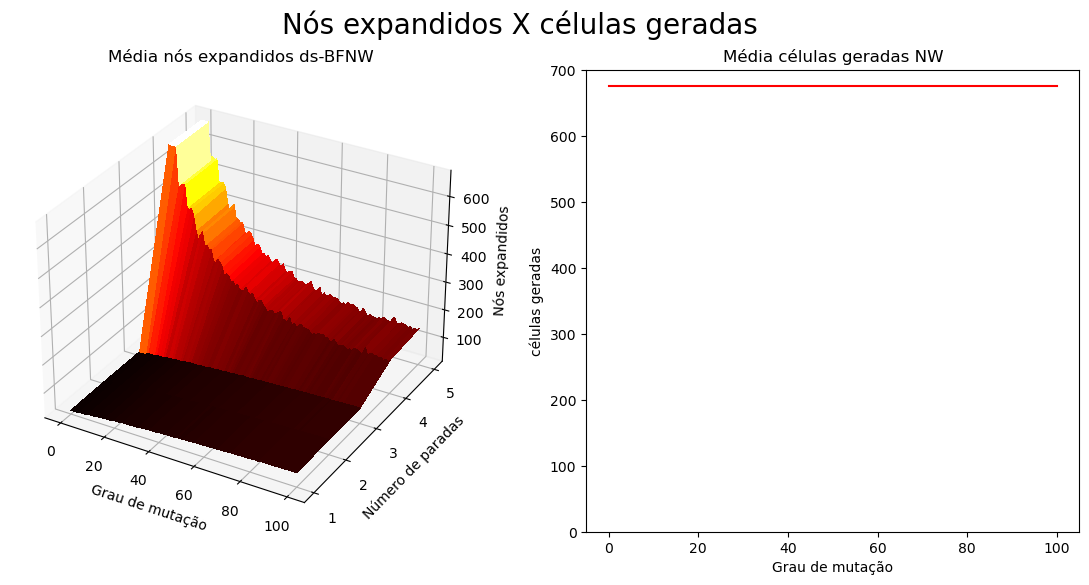

In [21]:
fig = plt.figure(figsize=(14, 6))
fig.suptitle('Nós expandidos X células geradas', fontsize=20)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('Média nós expandidos ds-BFNW')
ax.set_xlabel('Grau de mutação')
ax.set_ylabel('Número de paradas')
ax.set_yticks(range(1,6))
ax.set_zlabel('Nós expandidos')

surf = ax.plot_surface(X, Y, ds_bfnw_nos_expandidos_medios, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
#fig.colorbar(surf, shrink=0.5, aspect=5)

ax = fig.add_subplot(1, 2, 2)
ax.plot(X_original, nw_media_celulas_geradas, color='red')
ax.set_title('Média células geradas NW')
ax.set_xlabel('Grau de mutação')
ax.set_ylabel('células geradas')
ax.set_ylim(0, 700)

plt.show()

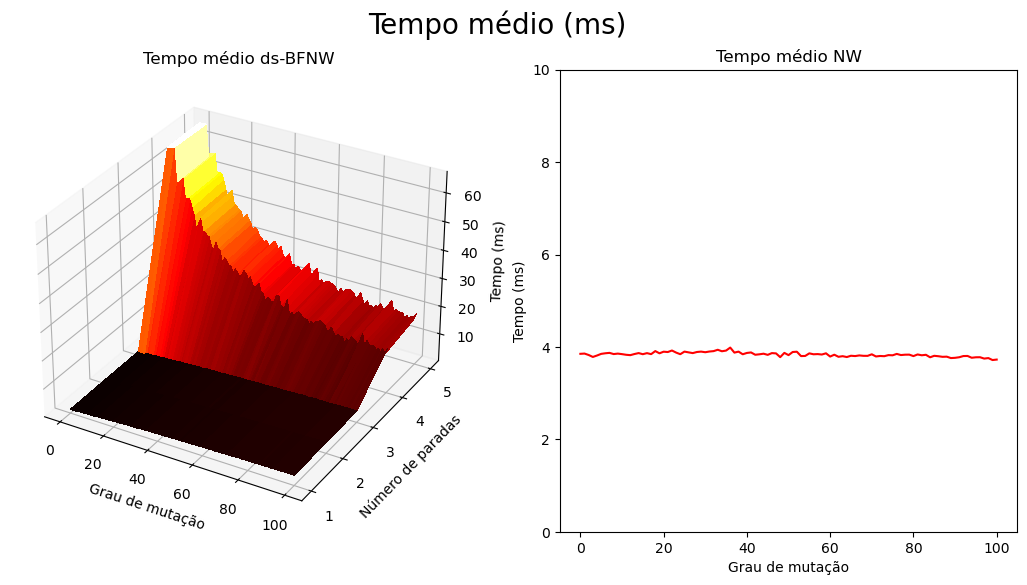

In [22]:
fig = plt.figure(figsize=(13, 6))
fig.suptitle('Tempo médio (ms)', fontsize=20)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('Tempo médio ds-BFNW')
ax.set_xlabel('Grau de mutação')
ax.set_ylabel('Número de paradas')
ax.set_yticks(range(1,6))
ax.set_zlabel('Tempo (ms)')

ax.plot_surface(X, Y, ds_bfnw_tempo_medio, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)

ax = fig.add_subplot(1, 2, 2)
ax.plot(X_original, nw_tempo_medio, color='red')
ax.set_title('Tempo médio NW')
ax.set_xlabel('Grau de mutação')
ax.set_ylabel('Tempo (ms)')
ax.set_ylim(0, 10)

plt.show()

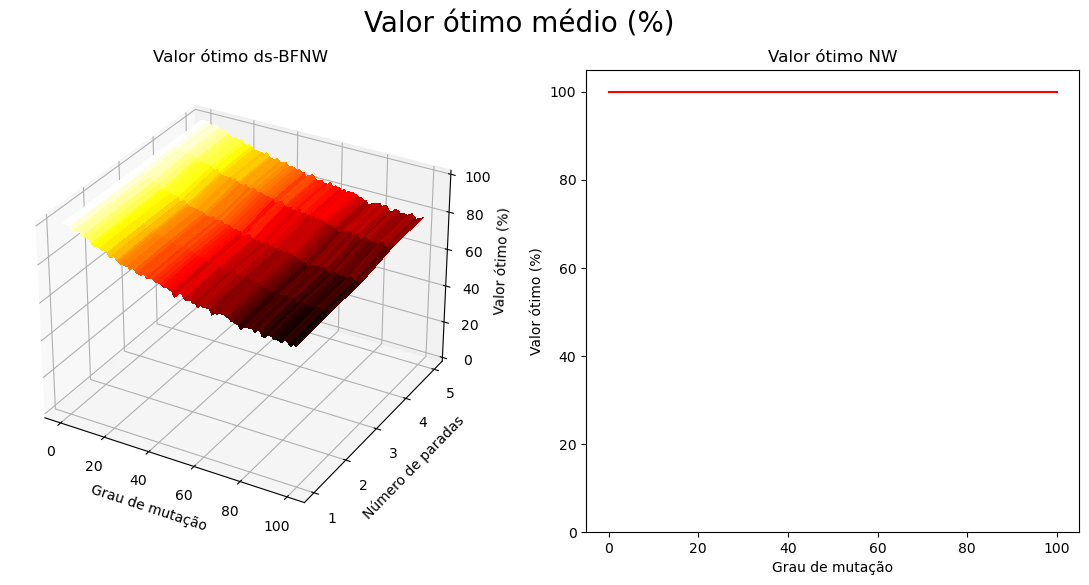

In [23]:
fig = plt.figure(figsize=(14, 6))
fig.suptitle('Valor ótimo médio (%)', fontsize=20)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('Valor ótimo ds-BFNW')
ax.set_xlabel('Grau de mutação')
ax.set_ylabel('Número de paradas')
ax.set_yticks(range(1,6))
ax.set_zlabel('Valor ótimo (%)')
ax.set_zlim(0, 100)

ax.plot_surface(X, Y, ds_bfnw_porcentagem_valor_otimo_medio, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)

ax = fig.add_subplot(1, 2, 2)
ax.plot(X_original, nw_porcentagem_valor_otimo_medio, color='red')
ax.set_title('Valor ótimo NW')
ax.set_xlabel('Grau de mutação')
ax.set_ylabel('Valor ótimo (%)')
ax.set_ylim(0, 105)

plt.show()

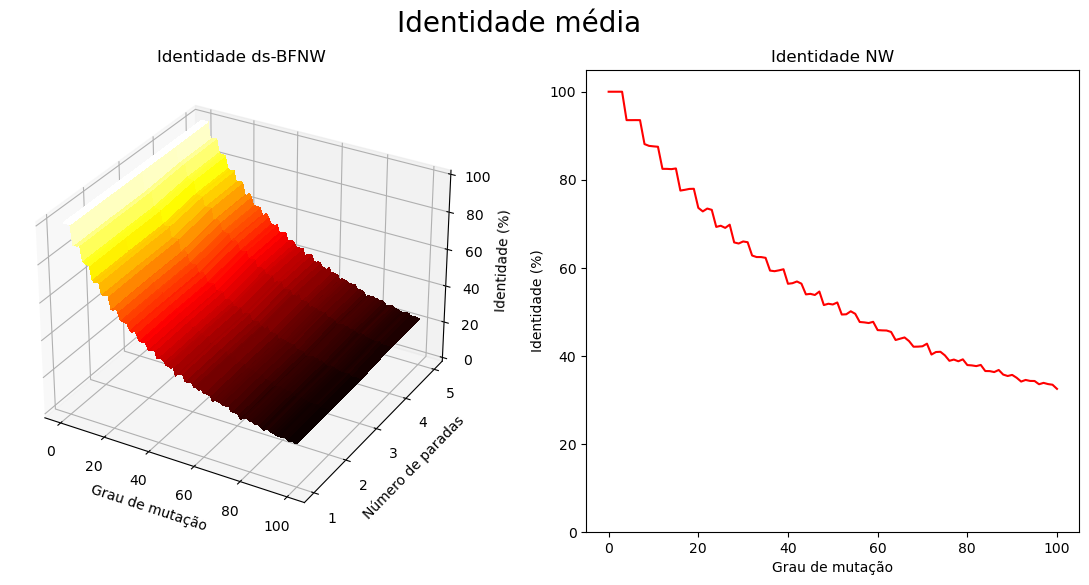

In [24]:
fig = plt.figure(figsize=(14, 6))
fig.suptitle('Identidade média', fontsize=20)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('Identidade ds-BFNW')
ax.set_xlabel('Grau de mutação')
ax.set_ylabel('Número de paradas')
ax.set_yticks(range(1,6))
ax.set_zlabel('Identidade (%)')
ax.set_zlim(0, 100)

ax.plot_surface(X, Y, ds_bfnw_identidade_media, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)

ax = fig.add_subplot(1, 2, 2)
ax.plot(X_original, nw_identidade_media, color='red')
ax.set_title('Identidade NW')
ax.set_xlabel('Grau de mutação')
ax.set_ylabel('Identidade (%)')
ax.set_ylim(0, 105)

plt.show()

Pela análise dos resultados acima, o que mais chama atenção é que, para todos os gráficos, há uma quebra abrupta nas tendências para o eixo do número de paradas quando o algoritmo começa a computar o ds-BFNW com 4 paradas. Esse evento fica mais evidente no gráfico de Nós expandidos e isso acontece pois, na média, para os parâmetros configurados, 4 paradas são suficientes para que o algoritmo já encontre a solução máxima real e começe a excessivamente procurar outros caminhos sem melhora, tanto é que, para alguns valores, ele expande literalmente todos os nós (ou seja, a condição de parada não foi o numero de *stops* alcançados, mas sim a ausência de nós na *heap* para expandir). Esse evento é indesejado pois, por mais que os resultados do alinhamento sejam absolutamente ótimos (nos gráficos, esses valores não estão exatamente no 100%/máximo possível pois eles representam uma média geral), assim como discutido acima, expandir todos os nós é completamente ineficiente e seria preferível só realizar o NW original em vez disso.  

Por outro lado, se compararmos os resultados obtidos com o número de paradas apenas entre 1 e 3, concluiremos que o ds-BFNW com 3 paradas computou um alinhamento absolutamente melhor em relação ao BFNW padrão (número de paradas igual a 1) para todos os graus de mutação, afinal, o número de nós expandidos não aumentou muito, mas o ganho na porcentagem do valor ótimo e na identidade são notáveis. Além disso, o *tradeoff* de tempo foi relativamente barato para uma solução que conseguiu se aproximar um pouco mais aos resultados ótimos do NW original.  

Finalmente, por mais que a qualidade estatística desse método seja superior ao BFNW básico, a utilidade prática dessa solução é questionável no sentido de que pode ser custoso descobrir a quantidade ideal de paradas para um problema qualquer.

## Testes com proteinas reais

Por fim, iremos novamente avaliar esse novo algoritmo ao alinhar sequências reais. As *strings* que usaremos serão as mesmas glicoproteínas *spike* dos vírus SARS-CoV e SARS-CoV-2 usadas em testes anteriores.

In [25]:
spike_sars_cov = "MVSAIVLYVLLAAAAHSAFASDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFDNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDTWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCSFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKPSGRLVPRGSPGSGYIPEAPRDGQAYVRKDGEWVLLSTFLGHHHHHH"
spike_sars_cov_2 = "MGILPSPGMPALLSLVSLLSVLLMGCVAETGMFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSRASSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELD"

In [26]:
# Executando Needleman-Wunsch original
tempo_inicial_nw = datetime.now()
matriz_posicionamento_nw, matriz_similaridade_nw = nw_original.needleman_wunsch_iterativo(v=spike_sars_cov, w=spike_sars_cov_2)
tempo_final_nw = datetime.now()

# Executando BFNW
tempo_inicial_bfnw = datetime.now()
matriz_posicionamento_bfnw, matriz_similaridade_bfnw = delayed_stop_bfnw(v=spike_sars_cov, w=spike_sars_cov_2, num_stops=1) # É só chamar o método criado acima com num_stops=1
tempo_final_bfnw = datetime.now()

In [31]:
# Executando ds-BFNW com num_stops=5
tempo_inicial_ds_bfnw_5 = datetime.now()
matriz_posicionamento_ds_bfnw_5, matriz_similaridade_ds_bfnw_5 = delayed_stop_bfnw(v=spike_sars_cov, w=spike_sars_cov_2, num_stops=5)
tempo_final_ds_bfnw_5 = datetime.now()

# Executando ds-BFNW com num_stops=10
tempo_inicial_ds_bfnw_10 = datetime.now()
matriz_posicionamento_ds_bfnw_10, matriz_similaridade_ds_bfnw_10 = delayed_stop_bfnw(v=spike_sars_cov, w=spike_sars_cov_2, num_stops=10)
tempo_final_ds_bfnw_10 = datetime.now()

In [32]:
print("----- Média células geradas X Nós expandidos médios -----")
print("NW:", matriz_similaridade_nw.shape[0] * matriz_similaridade_nw.shape[1], "células geradas")
print("BFNW:", np.count_nonzero(matriz_similaridade_bfnw != (-np.inf)), "nós expandidos")
print("ds-BFNW 5 stops:", np.count_nonzero(matriz_similaridade_ds_bfnw_5 != (-np.inf)), "nós expandidos")
print("ds-BFNW 10 stops:", np.count_nonzero(matriz_similaridade_ds_bfnw_10 != (-np.inf)), "nós expandidos")

print("\n----- Tempo levado -----")
print("NW:", (tempo_final_nw - tempo_inicial_nw).total_seconds() * 1000, "ms")
print("BFNW:", (tempo_final_bfnw - tempo_inicial_bfnw).total_seconds() * 1000, "ms")
print("ds-BFNW 5 stops:", (tempo_final_ds_bfnw_5 - tempo_inicial_ds_bfnw_5).total_seconds() * 1000, "ms")
print("ds-BFNW 10 stops:", (tempo_final_ds_bfnw_10 - tempo_inicial_ds_bfnw_10).total_seconds() * 1000, "ms")

print("\n----- Valor ótimo-----")
print("NW:", matriz_similaridade_nw[len(spike_sars_cov), len(spike_sars_cov_2)])
print("BFNW:", matriz_similaridade_bfnw[len(spike_sars_cov), len(spike_sars_cov_2)])
print("ds-BFNW 5 stops:", matriz_similaridade_ds_bfnw_5[len(spike_sars_cov), len(spike_sars_cov_2)])
print("ds-BFNW 10 stops:", matriz_similaridade_ds_bfnw_10[len(spike_sars_cov), len(spike_sars_cov_2)])

print("\n----- Alinhamento e Identidade -----")
alin_v_nw, alin_w_nw = func_utils.computar_alinhamento(spike_sars_cov, spike_sars_cov_2, matriz_posicionamento_nw)
alin_v_bfnw, alin_w_bfnw = func_utils.computar_alinhamento(spike_sars_cov, spike_sars_cov_2, matriz_posicionamento_bfnw)
alin_v_ds_bfnw_5, alin_w_ds_bfnw_5 = func_utils.computar_alinhamento(spike_sars_cov, spike_sars_cov_2, matriz_posicionamento_ds_bfnw_5)
alin_v_ds_bfnw_10, alin_w_ds_bfnw_10 = func_utils.computar_alinhamento(spike_sars_cov, spike_sars_cov_2, matriz_posicionamento_ds_bfnw_10)

print("NW:", func_utils.computar_porcentagem_identidade(alin_v_nw, alin_w_nw))
print(alin_v_nw[:100])
print(alin_w_nw[:100])
print("\nBFNW:", func_utils.computar_porcentagem_identidade(alin_v_bfnw, alin_w_bfnw))
print(alin_v_bfnw[:100])
print(alin_w_bfnw[:100])
print("\nds-BFNW 5 stops:", func_utils.computar_porcentagem_identidade(alin_v_ds_bfnw_5, alin_w_ds_bfnw_5))
print(alin_v_ds_bfnw_5[:100])
print(alin_w_ds_bfnw_5[:100])
print("\nds-BFNW 10 stops:", func_utils.computar_porcentagem_identidade(alin_v_ds_bfnw_10, alin_w_ds_bfnw_10))
print(alin_v_ds_bfnw_10[:100])
print(alin_w_ds_bfnw_10[:100])

----- Média células geradas X Nós expandidos médios -----
NW: 1470144 células geradas
BFNW: 3683 nós expandidos
ds-BFNW 5 stops: 3776 nós expandidos
ds-BFNW 10 stops: 4131 nós expandidos

----- Tempo levado -----
NW: 9830.096 ms
BFNW: 514.9899999999999 ms
ds-BFNW 5 stops: 558.667 ms
ds-BFNW 10 stops: 758.3 ms

----- Valor ótimo-----
NW: 4898.0
BFNW: 1638.0
ds-BFNW 5 stops: 1651.0
ds-BFNW 10 stops: 1657.0

----- Alinhamento e Identidade -----
NW: 63.24167872648335
M-V--S----A---IV-LY--VLL-AAAAHS---AF-------ASDLDRC---TTFDD-VQA-PN--YTQHTS-SMRGVYYPDEIFRSDT-LYL-TQDLF
MGILPSPGMPALLSLVSL-LSVLLMGCVAETGMFVFLVLLPLVSS---QCVNLTT---RTQ-LP-PAYT-N-SFT-RGVYYPDKVFRS-SVLH-STQDLF

BFNW: 12.047511312217194
M-V--S-AI--VLY-VLLA--A---A----AHSA-FASDLDR---CTTFDDVQAP--NYTQ--H-TS-SMRGVYYP----DEIFRSDT--LYLTQDLFLP
MGILPSPGMPALL-SLV-SLLSVLL-MGCVAETGMF---V--FLV---L--L--PLVS-SQCVNLTTRT-Q-L--PPAYTNS-F-T--RGVY-----Y-P

ds-BFNW 5 stops: 12.160633484162895
M-V--S-AI--VLY-VLLA--A---A----AHSA-FASDLDR---CTTFDDVQAP--NYTQ--H-

In [28]:
# Executando ds-BFNW com stops variando de 2 a 50

MAX_NUM_STEPS = 50

nos_expandidos = np.zeros(MAX_NUM_STEPS-1)
tempo = np.zeros(MAX_NUM_STEPS-1)
valor_otimo = np.zeros(MAX_NUM_STEPS-1)
identidade = np.zeros(MAX_NUM_STEPS-1)

for num_stops in range(2, MAX_NUM_STEPS+1):
    tempo_inicial = datetime.now()
    matriz_posicionamento, matriz_similaridade = delayed_stop_bfnw(v=spike_sars_cov, w=spike_sars_cov_2, num_stops=num_stops)
    tempo_final = datetime.now()
    
    nos_expandidos[num_stops-2] = np.count_nonzero(matriz_similaridade != (-np.inf))
    tempo[num_stops-2] = (tempo_final - tempo_inicial).total_seconds() * 1000
    valor_otimo[num_stops-2] = matriz_similaridade[len(spike_sars_cov), len(spike_sars_cov_2)]
    alin_v, alin_w = func_utils.computar_alinhamento(spike_sars_cov, spike_sars_cov_2, matriz_posicionamento)
    identidade[num_stops-2] = func_utils.computar_porcentagem_identidade(alin_v, alin_w)

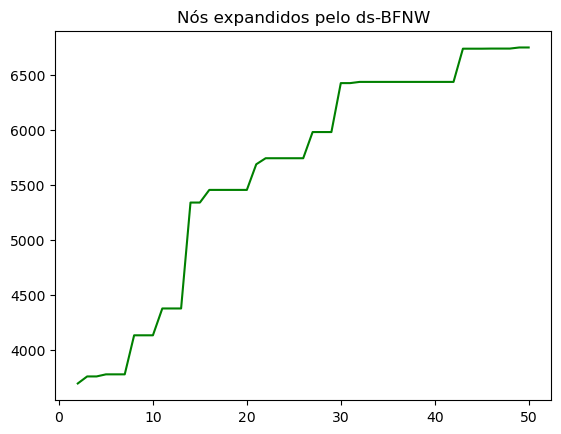

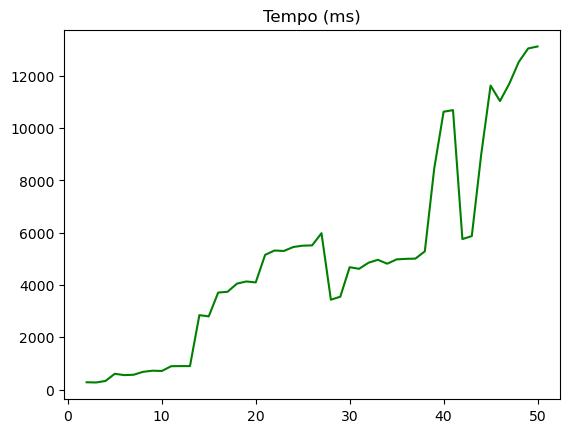

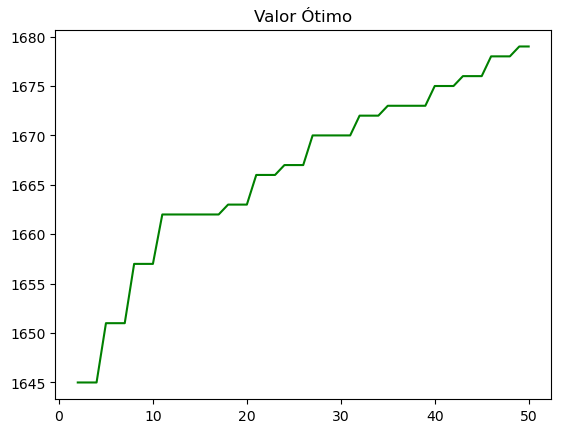

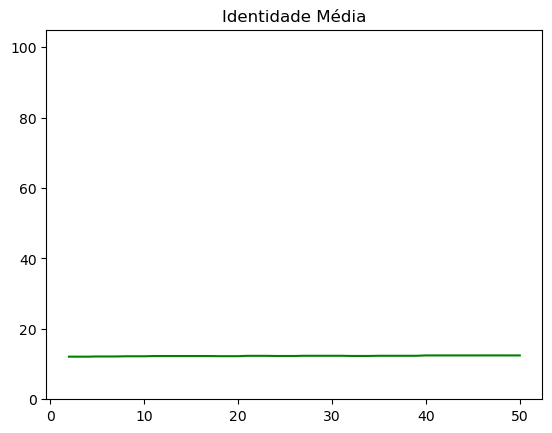

In [29]:
# Plottando os valores das execuções do ds-BFNW
plt.plot(np.arange(2, MAX_NUM_STEPS+1), nos_expandidos, color="green")
plt.title("Nós expandidos pelo ds-BFNW")
plt.show()

plt.plot(np.arange(2, MAX_NUM_STEPS+1), tempo, color="green")
plt.title("Tempo (ms)")
plt.show()

plt.plot(np.arange(2, MAX_NUM_STEPS+1), valor_otimo, color="green")
plt.title("Valor Ótimo")
plt.show()

plt.plot(np.arange(2, MAX_NUM_STEPS+1), identidade, color="green")
plt.title("Identidade Média")
plt.ylim(0, 105)
plt.show()

Novamente, pela análise dos gráficos gerados e dos resultados sintéticos apresentados na tabela acima, concluímos que o ds-BFNW não representa uma melhora tão significativa em relação ao BFNW padrão, entregando soluções com quase a mesma identidade mas consumindo um pouco mais de tempo. Mesmo que esse algoritmo seja preferível, ainda teríamos o custo de deduzir qual o número de paradas ideal para que se tenha um tradeoff razoável entre tempo e qualidade, afinal, pelos gráficos acima, mesmo com 50 stops, os resultados ainda não melhoraram muito, indicando que deveríamos/poderíamos explorar ainda mais o espaço de busca do grafo.